In [463]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [464]:
df = pd.read_csv("score.csv")
df.head()

,Hours,Scores
0,2.5,21
1,5.1,47
2,3.2,27
3,8.5,75
4,3.5,30


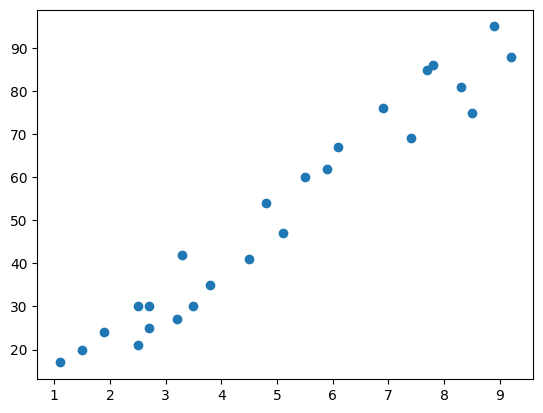

In [465]:
plt.scatter(x=df["Hours"], y=df["Scores"])

In [466]:
def gradient_descent(vals, m, b, lr):
    
    m_grad = 0
    b_grad = 0

    for i in range(len(vals["Hours"])):
        x = vals["Hours"][i]
        y = vals["Scores"][i]

        guess = (m * x) + b
        err = y - guess

        m_grad += -2 * x * err
        b_grad += -2 * err 

        """ 
        d/dslope = -2x(err)
        d/dintercept = -2(err)
        """
    m_grad /= len(vals["Hours"])
    b_grad /= len(vals["Hours"])
        
    m = m - (m_grad * lr) 
    b = b - (b_grad * lr)

    return m,b


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
9.890373374470345 1.7738923157459043


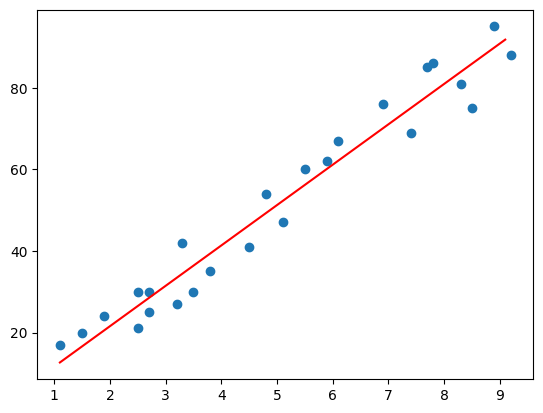

In [467]:
iterations = 1000
m = 1
b = 0
lr = 0.001


plt.scatter(x=df["Hours"], y=df["Scores"])
 
for i in range(iterations):
   if i % 50 == 0:
      print(i)
   m, b = gradient_descent(df, m, b, lr)


print(m,b)
x_vals = np.arange(min(df["Hours"]), max(df["Hours"]), 1)

plt.plot(x_vals, [m * x + b for x in x_vals], color="red")
